# Knowledge Based Recommendation System of Recipe Ingredients
## Notebook 3: Recommend Similar Ingredients using Word2Vec and Cosine Similarity
### Project Breakdown
    1  Exploratory Data Analysis and Preprocessing
    2: Build Word Embeddings using Word2Vec, FastText
    3: Recommend similar ingredients
    4: Build and Visualize Interactive Knowledge Graph of Ingredients



In [64]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np

import matplotlib
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

import nltk
nltk.download('wordnet')

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
# download word2vec model trained in Notebook 2
!mkdir -p models
!gdown --id 198GyP3N6nWvEz90SA000XOIY6aGWPs0J -O models/word2vec.model
!gdown --id 1-GyTcxtHJflJfgsV-3mVQVsfLStsGF6i -O models/fasttext.vec

Downloading...
From: https://drive.google.com/uc?id=198GyP3N6nWvEz90SA000XOIY6aGWPs0J
To: /content/models/word2vec.model
100% 79.6M/79.6M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-GyTcxtHJflJfgsV-3mVQVsfLStsGF6i
To: /content/models/fasttext.vec
100% 56.8M/56.8M [00:00<00:00, 181MB/s] 


In [60]:
# load word embeddings from word2vec model
model = Word2Vec.load('models/word2vec.model')
model.init_sims(replace=True)  # we will no longer train the model

In [ ]:
# read list of items to recommend
with open('data/items_for_sale.txt', 'r') as f:
    items_for_sale = f.read()

items_for_sale = items_for_sale.split('\n')

In [70]:
wnl = WordNetLemmatizer()
items, vectors = [], []

for item in items_for_sale:
    try:
        item = wnl.lemmatize(item)
        vectors.append(model.wv.get_vector(item))
        items.append(item)

    except KeyError:
        print(f"we don't have {item} in vocab ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [71]:
 len(items)

911

In [ ]:
# Now, we want to get similarity across all the words in our  vocab
sims = cosine_similarity(vectors, vectors)
sims

array([[ 0.9999999 ,  0.08102269,  0.13157023, ...,  0.03962789,
        -0.0349462 , -0.06848071],
       [ 0.08102269,  0.9999999 ,  0.11258712, ..., -0.03310471,
        -0.0155591 , -0.0396278 ],
       [ 0.13157023,  0.11258712,  1.0000001 , ...,  0.22723201,
        -0.09522239, -0.0367922 ],
       ...,
       [ 0.0396279 , -0.03310472,  0.22723195, ...,  1.0000001 ,
         0.02715159, -0.08260366],
       [-0.03494618, -0.01555911, -0.09522238, ...,  0.02715159,
         1.0000004 ,  0.09454656],
       [-0.06848071, -0.0396278 , -0.0367922 , ..., -0.08260366,
         0.09454656,  1.0000002 ]], dtype=float32)

In [ ]:
# we do have duplicate information in diagonals,
# and in one diagonal section too.
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i <= j:
            sims[i, j] = False

In [ ]:
# To visualize our similarity matrix, we can take random sample of 15 items
k = 15
idxs = list(range(len(vectors)))
random.shuffle(idxs)

small_idxs = idxs[:k]
small_vectors = [vectors[idx] for idx in small_idxs]
small_items = [items[idx] for idx in small_idxs]

small_sims = cosine_similarity(small_vectors, small_vectors)
for idx in range(len(small_vectors)):
    small_sims[idx, idx] = 0

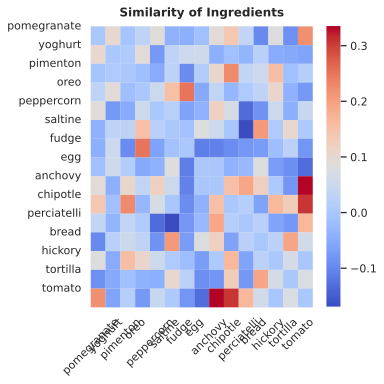

In [ ]:
# adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax = sns.heatmap(small_sims, annot=False, cmap= 'coolwarm')
ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_items)
ax.set_yticklabels(small_items)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=45)
plt.setp(ax.get_yticklabels(), rotation=0)
fig.tight_layout()

plt.title('Similarity of Ingredients')
plt.show()

Heatmap is symmetrical across the diagonal. We can see tomato is similar to anchovy, chipotle, but is very different from oreo.

In [57]:
# save 
np.savetxt('data/items.txt', items, fmt='%s')
np.save('data/w2v_vectors.npy', vectors)